In [1]:
from save_load import save_model, load_model, save_feature, load_feature
from utils import import_images, make_label
from LocalFeature import LocalFeature
import numpy as np
import pandas as pd
import cv2
import preprocessing
from general_model import LogisticModel, SVMModel, StandardScaling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import copy

In [23]:
from sklearn import metrics
import matplotlib.pyplot as plt
def metric(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    return matrix,accuracy,precision,recall,f1

def plot_roc(y1, y2, prob_list,classes):
    fpr = []
    tpr = []
    roc_auc = []
    for i,name in enumerate(classes):
        if name == 'SIFT BOVW':
            f, t, _ = metrics.roc_curve(y2, prob_list[i], pos_label=1)
            ra = metrics.roc_auc_score(y2, prob_list[i])
            fpr.append(f)
            tpr.append(t)
            roc_auc.append(ra)
            continue
        f, t, _ = metrics.roc_curve(y1, prob_list[i], pos_label=1)
        ra = metrics.roc_auc_score(y1, prob_list[i])
        fpr.append(f)
        tpr.append(t)
        roc_auc.append(ra)

    plt.figure(figsize=(12, 6))
    colors = [ 'red','orange', 'purple']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i],label='ROC curve for ' + classes[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<h3>Import images in original and grayscale

In [4]:
p_img, p_grey = import_images(r'/Users/parth/ML/Project/cell_images/Parasitized/*.png')
u_img, u_grey = import_images(r'/Users/parth/ML/Project/cell_images/Uninfected/*.png')

In [5]:
original_image = p_img.copy()
original_image.extend(u_img)
gray_image = p_grey.copy()
gray_image.extend(u_grey)

In [6]:
save_feature(original_image,'./features_pkl/original_images')
save_feature(gray_image,'./features_pkl/original_images_gray')

Successfully saved features
Successfully saved features


In [3]:
original_image = load_feature('./features_pkl/original_images.pkl')
gray_image = load_feature('./features_pkl/original_images_gray.pkl')
print("Original shape:",len(original_image))
print("Gray shape:",len(gray_image))

Original shape: 27558
Gray shape: 27558


In [4]:
label = make_label(27558)
label.shape

(27558,)

<h3>Resize Gray image

In [9]:
np_img = preprocessing.resize_image(original_image, 27558, 64)
save_feature(np_img,'./features_pkl/raw_resized_features')

Successfully saved features


In [5]:
np_img = load_feature('./features_pkl/raw_resized_features.pkl')
print(np_img.shape)

(27558, 64, 64, 3)


<h3> Global feature extraction on raw images

In [ ]:
np_original = preprocessing.global_feature_extractor(gray_image, 27558)
save_feature(np_original,'./features_pkl/global_raw_image_features')

In [114]:
np_original = load_feature('./features_pkl/global_raw_image_features.pkl')
print(np_original.shape)

(27558, 28)


<h3>Global feature extraction on canny filter

In [ ]:
%%time
canny_images = preprocessing.canny_preprocessing(gray_image, 27558)
np_canny = preprocessing.global_feature_extractor(canny_images, 27558)
save_feature(np_canny,'./features_pkl/global_canny_image_features')

In [115]:
np_canny = load_feature('./features_pkl/global_canny_image_features.pkl')
print(np_canny.shape)

(27558, 28)


<h3>Global feature extraction on clahe filter

In [ ]:
%%time
clahe_images = preprocessing.clahe_preprocessing(gray_image, 27558)
np_clahe = preprocessing.global_feature_extractor(clahe_images, 27558)
save_feature(np_clahe,'./features_pkl/global_clahe_image_features')

In [116]:
np_clahe = load_feature('./features_pkl/global_clahe_image_features.pkl')
print(np_clahe.shape)

(27558, 28)


<h3>Global feature extraction on sobel edge detection

In [ ]:
%%time
sobel_images = preprocessing.sobel_preprocessing(gray_image, 27558)
np_sobel = preprocessing.global_feature_extractor(sobel_images, 27558)
save_feature(np_sobel,'./features_pkl/global_sobel_image_features')

In [117]:
np_sobel = load_feature('./features_pkl/global_sobel_image_features.pkl')
print(np_sobel.shape)

(27558, 28)


<h3>Global feature extraction on scharr edge detection

In [ ]:
%%time
scharr_images = preprocessing.scharr_preprocessing(gray_image, 27558)
np_scharr = preprocessing.global_feature_extractor(scharr_images, 27558)
save_feature(np_scharr,'./features_pkl/global_scharr_image_features')

In [118]:
np_scharr = load_feature('./features_pkl/global_scharr_image_features.pkl')
print(np_scharr.shape)

(27558, 28)


<h3>Global feature test accuracy on baseline model

In [21]:
ll = ['raw', 'canny', 'clahe', 'scharr', 'sobel']
log_acc = []
svc_acc = []
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_test = StandardScaling(x_train,x_test)
    x_train = StandardScaling(x_train,x_train)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    print("Training Done for :", itr)

Training Done for : raw
Training Done for : canny
Training Done for : clahe
Training Done for : scharr
Training Done for : sobel


In [22]:
df = pd.DataFrame({'Model' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc})
df

,Model,Logistic Accuracy,SVM Accuracy
0,raw,0.862554,0.870682
1,canny,0.845718,0.860958
2,clahe,0.824964,0.847896
3,scharr,0.894194,0.895065
4,sobel,0.915385,0.908128


<h3>SIFT and KAZE

In [14]:
%%time
ll = ['SIFT', 'KAZE']
log_acc = []
svc_acc = []
for itr in ll:
    LF = LocalFeature(feature_type = itr, cluster_size = 50, test_size = 0.25, image_type = 'original')
    x_train, x_test, y_train, y_test = LF.fit(np_img)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    print("Training Done")

    
df = pd.DataFrame({'Feature Type' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc})
df

27204 27204
Training Done
27556 27556
Training Done
CPU times: user 25min 5s, sys: 3min 48s, total: 28min 53s
Wall time: 5min 41s


,Feature Type,Logistic Accuracy,SVM Accuracy
0,SIFT,0.902808,0.908984
1,KAZE,0.672812,0.685441


In [9]:
%%time
ll = ['canny', 'clahe', 'scharr', 'sobel']
log_acc = []
svc_acc = []
for idx, itr in enumerate(ll):
    LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'filtered')
    if itr == 'canny':
        data = preprocessing.canny_preprocessing(gray_image, 27558)
    elif itr == 'clahe':
        data = preprocessing.clahe_preprocessing(gray_image, 27558)
    elif itr == 'scharr':
        data = preprocessing.scharr_preprocessing(gray_image, 27558)
    elif itr == 'sobel':
        data = preprocessing.sobel_preprocessing(gray_image, 27558)
    img = preprocessing.resize_image(data, 27558, 64)
    x_train, x_test, y_train, y_test = LF.fit(img)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    print("For Preprocessing :", ll)
    print("Logistic Accuracy :", log_acc[idx])
    print("SVM Accuracy", svc_acc[idx])
    
    
df = pd.DataFrame({'Feature Type' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc})
df

18154 18154
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.8197840934126459
SVM Accuracy 0.82088565763384
27543 27543
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.8613128085971536
SVM Accuracy 0.8768515829218705
17841 17841
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.7953373683030711
SVM Accuracy 0.8058731226182471
18881 18881
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.7968650709595425
SVM Accuracy 0.8013132810845159
CPU times: user 26min 32s, sys: 4min 28s, total: 31min
Wall time: 8min 52s


,Feature Type,Logistic Accuracy,SVM Accuracy
0,canny,0.819784,0.820886
1,clahe,0.861313,0.876852
2,scharr,0.795337,0.805873
3,sobel,0.796865,0.801313


In [11]:
%%time
ll = ['canny', 'clahe', 'scharr', 'sobel']
log_acc = []
svc_acc = []
for idx, itr in enumerate(ll):
    LF = LocalFeature(feature_type = 'KAZE', cluster_size = 20, test_size = 0.25, image_type = 'filtered')
    if itr == 'canny':
        data = preprocessing.canny_preprocessing(gray_image, 27558)
    elif itr == 'clahe':
        data = preprocessing.clahe_preprocessing(gray_image, 27558)
    elif itr == 'scharr':
        data = preprocessing.scharr_preprocessing(gray_image, 27558)
    elif itr == 'sobel':
        data = preprocessing.sobel_preprocessing(gray_image, 27558)
    img = preprocessing.resize_image(data, 27558, 64)
    x_train, x_test, y_train, y_test = LF.fit(img)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    print("For Preprocessing :", ll)
    print("Logistic Accuracy :", log_acc[idx])
    print("SVM Accuracy", svc_acc[idx])
    
    
df = pd.DataFrame({'Feature Type' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc})
df

21234 21234
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.7532491994725937
SVM Accuracy 0.7534375588623092
27558 27558
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.7936139332365747
SVM Accuracy 0.8015965166908563
26550 26550
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.6780656824344682
SVM Accuracy 0.6925278698403133
26621 26621
For Preprocessing : ['canny', 'clahe', 'scharr', 'sobel']
Logistic Accuracy : 0.6850961538461539
SVM Accuracy 0.6935096153846154
CPU times: user 20min 25s, sys: 2min 14s, total: 22min 39s
Wall time: 9min 28s


,Feature Type,Logistic Accuracy,SVM Accuracy
0,canny,0.753249,0.753438
1,clahe,0.793614,0.801597
2,scharr,0.678066,0.692528
3,sobel,0.685096,0.693510


<h1>Grid Search CV

In [161]:
grid_search_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'scharr', 'sobel'])

In [162]:
parameters = {'kernel':('poly', 'rbf'), 'C': np.logspace(-2, 1, num = 10)}
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    svc = SVC(probability = True)
    clf = GridSearchCV(svc, parameters, refit = True, cv = 5, verbose = 3)
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_grid_search.pkl'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.793 total time=  55.7s
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.795 total time=  54.9s
[CV 3/5] END ...............C=0.01, kernel=poly;, score=0.776 total time=  54.7s
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.794 total time=  55.8s
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.789 total time= 3.8min
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.852 total time= 1.1min
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.854 total time= 2.2min
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.841 total time= 1.2min
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.852 total time= 1.2min
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.844 total time= 1.1min
[CV 1/5] END C=0.021544346900318832, kernel=poly;, score=0.817 total time=  54.0s
[CV 2/5] END C=0.021544346900318832, kernel=po

[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.803 total time=  57.0s
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.806 total time=  55.5s
[CV 3/5] END ...............C=0.01, kernel=poly;, score=0.784 total time=  56.8s
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.804 total time=  55.4s
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.804 total time=  55.1s
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.855 total time= 1.1min
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.859 total time= 1.1min
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.841 total time= 1.1min
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.859 total time= 1.1min
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.848 total time= 1.1min
[CV 1/5] END C=0.021544346900318832, kernel=poly;, score=0.828 total time=  51.2s
[CV 2/5] END C=0.021544346900318832, kernel=poly;, score=0.832 total time=  50.8s
[CV 3/5] END C=0.021544346

In [163]:
#Grid Search on SIFT
parameters = {'kernel':('poly', 'rbf'), 'C': np.logspace(-2, 1, num = 10)}
LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'original')
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_train = StandardScaling(x_train, x_train)
x_test = StandardScaling(x_train,x_test)
svc = SVC(probability = True)
clf = GridSearchCV(svc, parameters, refit = True, cv = 5, verbose = 3)
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_grid_search'
save_feature(clf, save_filename)


27204 27204
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.611 total time= 1.1min
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.618 total time= 1.1min
[CV 3/5] END ...............C=0.01, kernel=poly;, score=0.613 total time= 1.1min
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.621 total time= 1.1min
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.618 total time= 1.1min
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.870 total time= 1.2min
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.873 total time= 1.2min
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.858 total time= 1.2min
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.860 total time= 1.2min
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.867 total time= 1.2min
[CV 1/5] END C=0.021544346900318832, kernel=poly;, score=0.660 total time= 1.1min
[CV 2/5] END C=0.02154434690031883

<h3>Grid Search Cv model on test data

In [164]:
prob_grid = []

In [165]:
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features_grid_search.pkl.pkl'
    clf = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_test = StandardScaling(x_train,x_test)
    y_pred_test = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    prob_grid.append(y_pred_proba[:,1])
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
    print("LR : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    grid_search_df.loc[itr] = [accuracy,precision,recall,f1]

LR : Accuracy-0.9036284470246735 Precision-0.9153891509433962 Recall-0.8917288914417002 F1-0.903404131510038
LR : Accuracy-0.9168359941944848 Precision-0.9304527966854099 Recall-0.9029293509477312 F1-0.9164844774814167


In [18]:
y1 = copy.deepcopy(y_test)

In [167]:
#Prediction on SIFT Grid Search
filename = './features_pkl/local_'+ 'raw' + '_image_features_grid_search.pkl'
clf = load_feature(filename)
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_test = StandardScaling(x_train,x_test)
y_pred_test = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)
prob_grid.append(y_pred_proba[:,1])
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
print("LR : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
grid_search_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]

27204 27204
LR : Accuracy-0.9066313777385678 Precision-0.9098190447938297 Recall-0.9025897586815774 F1-0.906189983749446


In [168]:
y2 = copy.deepcopy(y_test)

In [169]:
grid_search_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.906631,0.909819,0.90259,0.90619
scharr,0.903628,0.915389,0.891729,0.903404
sobel,0.916836,0.930453,0.902929,0.916484


<h3> ROC Curve for Grid Search on all 3 preprocessing techniques

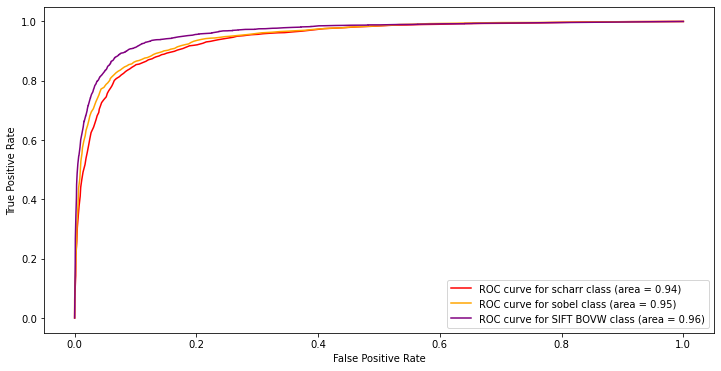

In [170]:
plot_roc(y1, y2, proba_random_tree, ['scharr', 'sobel', 'SIFT BOVW'])

<h1>Ensembling: Random Tree Classifier

In [122]:
random_tree_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'scharr', 'sobel'])

In [42]:
from sklearn.ensemble import RandomForestClassifier
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_random_tree'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)

Successfully saved features
Training Done for : scharr
Successfully saved features
Training Done for : sobel


In [43]:
#Random Tree on SIFT
LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'original')
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_train = StandardScaling(x_train, x_train)
x_test = StandardScaling(x_train,x_test)
clf = RandomForestClassifier()
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_random_tree'
save_feature(clf, save_filename)

27204 27204
Successfully saved features


<h3>Random Tree Predictions

In [123]:
proba_random_tree = []

In [124]:
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features_random_tree.pkl'
    clf = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_test = StandardScaling(x_train,x_test)
    y_pred_test = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    proba_random_tree.append(y_pred_proba[:,1])
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
    print("Random Tree : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    random_tree_df.loc[itr] = [accuracy,precision,recall,f1]

Random Tree : Accuracy-0.8735849056603774 Precision-0.8707753479125249 Recall-0.8805284319356692 F1-0.875624732257604
Random Tree : Accuracy-0.879100145137881 Precision-0.8781044818726805 Recall-0.8834003446295232 F1-0.8807444523979956


In [128]:
y1 = copy.deepcopy(y_test)

In [129]:
#Prediction on SIFT Random Tree
filename = './features_pkl/local_'+ 'raw' + '_image_features_random_tree.pkl'
clf = load_feature(filename)
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_test = StandardScaling(x_train,x_test)
y_pred_test = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)
proba_random_tree.append(y_pred_proba[:,1])
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
print("Random Tree : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
random_tree_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]

27204 27204
Random Tree : Accuracy-0.9061902661373328 Precision-0.9011627906976745 Recall-0.9123013537374927 F1-0.9066978648727698


In [16]:
y2 = copy.deepcopy(y_test)

In [101]:
random_tree_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.90619,0.901163,0.912301,0.906698
scharr,0.873585,0.870775,0.880528,0.875625
sobel,0.8791,0.878104,0.8834,0.880744


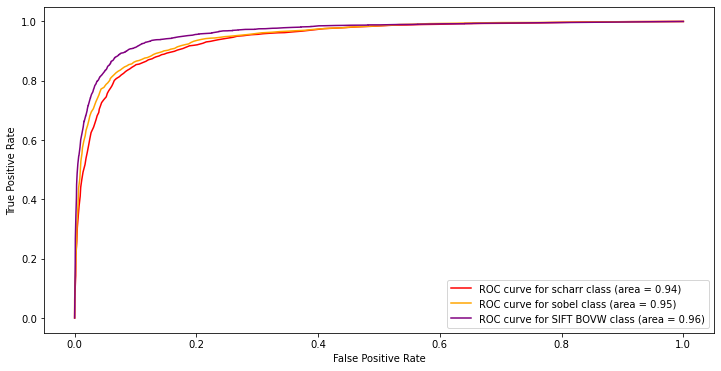

In [138]:
plot_roc(y1, y2, proba_random_tree, ['scharr', 'sobel', 'SIFT BOVW'])

<h1>Ensembling: Ada Boost

In [9]:
adaboost_dt_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'scharr', 'sobel'])

adaboost_lr_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'scharr', 'sobel'])

In [67]:
from sklearn.ensemble import AdaBoostClassifier
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    clf = AdaBoostClassifier(algorithm = 'SAMME')
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_adaboost_default'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)
    
lr = LogisticRegression()
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    clf = AdaBoostClassifier(base_estimator = lr, algorithm = 'SAMME')
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_adaboost_lr'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)

Successfully saved features
Training Done for : scharr
Successfully saved features
Training Done for : sobel
Successfully saved features
Training Done for : scharr
Successfully saved features
Training Done for : sobel


In [6]:
from sklearn.ensemble import AdaBoostClassifier
#Adaboost on SIFT
LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'original')
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_train = StandardScaling(x_train, x_train)
x_test = StandardScaling(x_train,x_test)
clf = AdaBoostClassifier(algorithm = 'SAMME')
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_default'
save_feature(clf, save_filename)

#SIFT on LR
lr = LogisticRegression()
clf = AdaBoostClassifier(base_estimator = lr, algorithm = 'SAMME')
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_lr'
save_feature(clf, save_filename)

27204 27204
Successfully saved features


<h3>Prediction on both adaboost estimators

In [35]:
prob_dt = []
prob_lr = []

In [36]:
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features_adaboost_default.pkl'
    clf_deafult = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features_adaboost_lr.pkl'
    clf_lr = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_test = StandardScaling(x_train,x_test)
    y_pred_default = clf_deafult.predict(x_test)
    y_pred_lr = clf_lr.predict(x_test)
    y_pred_proba = clf_deafult.predict_proba(x_test)
    prob_dt.append(y_pred_proba[:,1])
    y_pred_proba = clf_lr.predict_proba(x_test)
    prob_lr.append(y_pred_proba[:,1])
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_default)
    print("AdaBoost default : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    adaboost_dt_df.loc[itr] = [accuracy,precision,recall,f1]
    
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_lr)
    print("AdaBoost LR : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    adaboost_lr_df.loc[itr] = [accuracy,precision,recall,f1]

AdaBoost default : Accuracy-0.8471698113207548 Precision-0.8274467511458614 Recall-0.8813900057438254 F1-0.8535669586983731
AdaBoost LR : Accuracy-0.8378809869375907 Precision-0.830954380072768 Recall-0.8526708788052844 F1-0.8416725726435152
AdaBoost default : Accuracy-0.8548621190130624 Precision-0.8460680423870608 Recall-0.871338311315336 F1-0.858517260894171
AdaBoost LR : Accuracy-0.872278664731495 Precision-0.8764467592592593 Recall-0.869902354968409 F1-0.8731622946093976


In [37]:
#Prediction on SIFT Adaboost
filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_default.pkl'
clf_deafult = load_feature(filename)
filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_lr.pkl'
clf_lr = load_feature(filename)
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_test = StandardScaling(x_train,x_test)

y_pred_default = clf_deafult.predict(x_test)
y_pred_lr = clf_lr.predict(x_test)
y_pred_proba = clf_deafult.predict_proba(x_test)
prob_dt.append(y_pred_proba[:,1])
y_pred_proba = clf_lr.predict_proba(x_test)
prob_lr.append(y_pred_proba[:,1])
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_default)
print("AdaBoost default : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
adaboost_dt_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]
    
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_lr)
print("AdaBoost LR : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
adaboost_lr_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]

27204 27204
AdaBoost default : Accuracy-0.8742831936479929 Precision-0.9431857790170791 Recall-0.79635079458505 F1-0.8635710866443275
AdaBoost LR : Accuracy-0.8753124540508749 Precision-0.9161227154046997 Recall-0.826074161271336 F1-0.8687712782420304


In [38]:
adaboost_dt_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.874283,0.943186,0.796351,0.863571
scharr,0.84717,0.827447,0.88139,0.853567
sobel,0.854862,0.846068,0.871338,0.858517


In [39]:
adaboost_lr_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.875312,0.916123,0.826074,0.868771
scharr,0.837881,0.830954,0.852671,0.841673
sobel,0.872279,0.876447,0.869902,0.873162


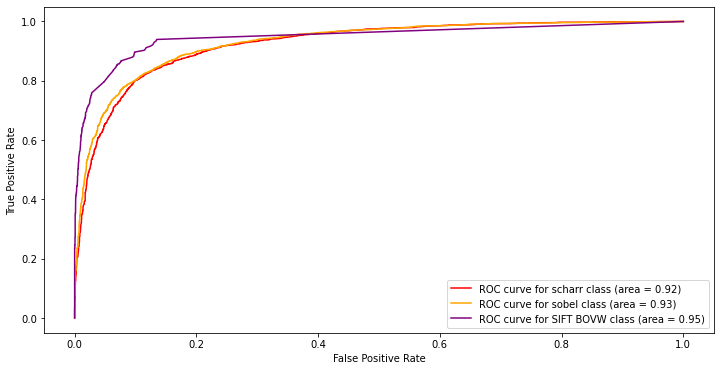

In [157]:
plot_roc(y1, y2, prob_dt, ['scharr', 'sobel', 'SIFT BOVW'])

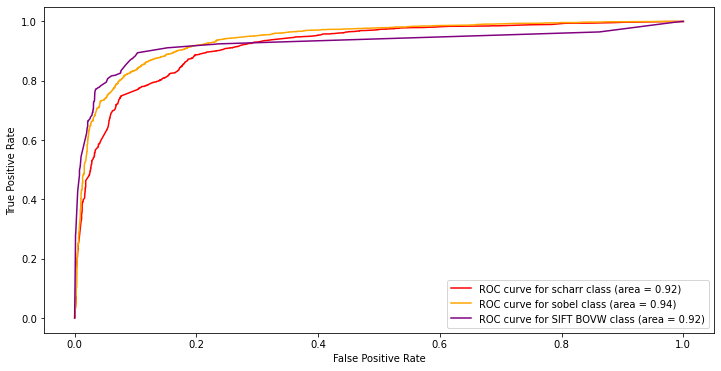

In [40]:
plot_roc(y1, y2, prob_lr, ['scharr', 'sobel', 'SIFT BOVW'])